# Trending Prediction Notebook

### Import the packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

### Read the original data file

In [2]:
df = pd.read_csv("../data/US_youtube_trending_data.csv")

### Preview the data after cleaning

In [3]:
df_cleaned = df.drop(columns=['channelId', 'channelTitle', 'tags', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description'], axis=1)
df_cleaned = df_cleaned[df_cleaned['view_count'] > 0]
df_cleaned["trending_date"]= pd.to_datetime(df_cleaned.trending_date)
df_cleaned["publishedAt"]= pd.to_datetime(df_cleaned.publishedAt)
df_cleaned = df_cleaned.groupby(['video_id']).filter(lambda x: len(x) > 4)
df_grouped = df_cleaned.drop(columns=['publishedAt', 'likes', 'dislikes', 'comment_count'])
df_grouped

,video_id,title,categoryId,trending_date,view_count
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,22,2020-08-12 00:00:00+00:00,1514614
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,20,2020-08-12 00:00:00+00:00,2381688
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,24,2020-08-12 00:00:00+00:00,2038853
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,10,2020-08-12 00:00:00+00:00,496771
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,26,2020-08-12 00:00:00+00:00,1123889
...,...,...,...,...,...
91185,mCeRv5Mj8No,MOM VS DAD ON HALLOWEEN NIGHT! 😳 #shorts,24,2021-11-04 00:00:00+00:00,2571844
91186,KeICh4_RHDA,Rabbert saves the world #teamseas,1,2021-11-04 00:00:00+00:00,3482219
91187,NkhSYcOu-eM,Hotboii - Never Say Never (Official Video),10,2021-11-04 00:00:00+00:00,660037
91188,s-8YrAIOLn0,Key Glock - Toolie (Official Video),10,2021-11-04 00:00:00+00:00,747255


### Get a dictionary containing dataset for training

In [4]:
video_ids = df_cleaned.video_id.unique()
df_grouped_by = df_cleaned.groupby(['video_id'])
video_dict = {}
for i in video_ids:
    video_dict[i] = df_grouped_by.get_group(i)

### Get a dictionary containing dataset for inference

In [5]:
start_date = df_grouped['trending_date'].max() + pd.DateOffset(-4)
end_date = df_grouped['trending_date'].max()
current_trending = df_grouped[df_grouped['trending_date'].between(start_date, end_date)]
current_trending = current_trending.groupby(['video_id']).filter(lambda x: len(x) > 3)
current_ids = current_trending.video_id.unique()

current_trending_group = current_trending.groupby(['video_id'])
current_dict = {}
for i in current_ids:
    current_dict[i] = current_trending_group.get_group(i).reset_index(drop=True)
current_dict

{'3hw_y9hI_js':       video_id                                  title  categoryId  \
 0  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 1  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 2  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 3  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 4  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 
               trending_date  view_count  
 0 2021-10-31 00:00:00+00:00     2323800  
 1 2021-11-01 00:00:00+00:00     3740879  
 2 2021-11-02 00:00:00+00:00     4691564  
 3 2021-11-03 00:00:00+00:00     5306715  
 4 2021-11-04 00:00:00+00:00     5674959  ,
 'cV2gBU6hKfY':       video_id                                           title  categoryId  \
 0  cV2gBU6hKfY  I Cleaned The World’s Dirtiest Beach #TeamSeas          24   
 1  cV2gBU6hKfY  I Cleaned The World’s Dirtiest Beach #TeamSeas          24   
 2  cV2gBU6hKfY  I Cleaned The World’s Dirtiest Beac

### Inference the data

In [6]:
for i in current_ids:
    category = int(current_dict[i].categoryId.unique())
    title = str(current_dict[i].title.unique()[0])
    trending_date = current_dict[i].trending_date.max() + pd.DateOffset(1)
    last_view_count = current_dict[i].view_count.max()
    x_points = list(current_dict[i].index)
    y_points = list(current_dict[i].view_count)
    tck = interpolate.splrep(x_points, y_points)
    view_count_pred = int(interpolate.splev(max(x_points) + 1, tck))
    if view_count_pred < last_view_count:
        view_count_pred = last_view_count + last_view_count - view_count_pred
    new_row = {'video_id': i, 'categoryId': category, 'trending_date': trending_date, 'view_count': view_count_pred}
    current_dict[i].loc[len(current_dict[i].index)] = [i, title, category, trending_date, view_count_pred]
current_dict

{'3hw_y9hI_js':       video_id                                  title  categoryId  \
 0  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 1  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 2  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 3  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 4  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 5  3hw_y9hI_js  What Your Early Twenties Will Be Like          23   
 
               trending_date  view_count  
 0 2021-10-31 00:00:00+00:00     2323800  
 1 2021-11-01 00:00:00+00:00     3740879  
 2 2021-11-02 00:00:00+00:00     4691564  
 3 2021-11-03 00:00:00+00:00     5306715  
 4 2021-11-04 00:00:00+00:00     5674959  
 5 2021-11-05 00:00:00+00:00     5874364  ,
 'cV2gBU6hKfY':       video_id                                           title  categoryId  \
 0  cV2gBU6hKfY  I Cleaned The World’s Dirtiest Beach #TeamSeas          24   
 1  cV2gBU6hKfY  I

### Plot one of the predicted trending

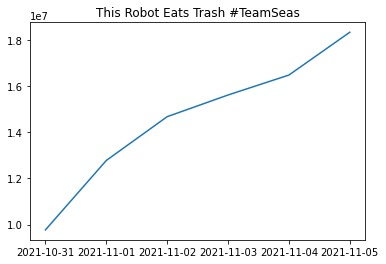

In [7]:
df_plot = current_dict['pXDx6DjNLDU']
title_plot = str(df_plot.title[0])
trending_date_plot = df_plot['trending_date']
view_count_plot = df_plot['view_count']
plt.plot(trending_date_plot, view_count_plot)
plt.title(title_plot)
plt.show()

### Show the data with predicted values

In [8]:
df_output = pd.DataFrame(columns=['video_id', 'title', 'categoryId', 'trending_date', 'view_count'])
for i in current_ids:
    df_output = df_output.append(current_dict[i], ignore_index=True)
df_output

,video_id,title,categoryId,trending_date,view_count
0,3hw_y9hI_js,What Your Early Twenties Will Be Like,23,2021-10-31 00:00:00+00:00,2323800
1,3hw_y9hI_js,What Your Early Twenties Will Be Like,23,2021-11-01 00:00:00+00:00,3740879
2,3hw_y9hI_js,What Your Early Twenties Will Be Like,23,2021-11-02 00:00:00+00:00,4691564
3,3hw_y9hI_js,What Your Early Twenties Will Be Like,23,2021-11-03 00:00:00+00:00,5306715
4,3hw_y9hI_js,What Your Early Twenties Will Be Like,23,2021-11-04 00:00:00+00:00,5674959
...,...,...,...,...,...
305,nLxmuh6wCVY,Highlights: Manchester United 0-5 Liverpool | ...,17,2021-11-01 00:00:00+00:00,11624683
306,nLxmuh6wCVY,Highlights: Manchester United 0-5 Liverpool | ...,17,2021-11-02 00:00:00+00:00,11729772
307,nLxmuh6wCVY,Highlights: Manchester United 0-5 Liverpool | ...,17,2021-11-03 00:00:00+00:00,11820085
308,nLxmuh6wCVY,Highlights: Manchester United 0-5 Liverpool | ...,17,2021-11-04 00:00:00+00:00,11895574
